In [13]:
# Imports + all input data + tunable constants.

from itertools import product as cartesian_product
import math
import pandas as pd
from IPython.display import display  # to show tables nicely in notebooks

# ---- Tunable constants (assumptions) ----
STAGING_DAYS_CD = 0.5   # average CD staging time in days (Little's Law)
GAMMA_RF = 5            # RF explosion factor: 1 reserve load -> 5 smaller forward loads

# ---- Sets ----
products = [1,2,3,4,5,6]
flows = [1,2,3,4]  # 1=CD, 2=R, 3=RF, 4=F
flow_name = {1:"CD", 2:"R", 3:"RF", 4:"F"}
areas = ["CD","R","F"]

# ---- Table 11.1 ----
D = {1:10000, 2:15000, 3:25000, 4:2000, 5:1500, 6:95000}          # annual demand (unit loads)
S = {1:50, 2:50, 3:50, 4:50, 5:50, 6:150}                         # order cost ($/order)
P = {1:500, 2:650, 3:350, 4:250, 5:225, 6:150}                    # price per unit load ($)
c_rate = {i:0.10 for i in products}                               # carrying cost rate
space = {1:10, 2:15, 3:25, 4:10, 5:12, 6:13}                      # m² per unit load

# RF reserve dwell fraction (only for RF)
alpha_reserve_RF = {1:0.0, 2:0.0, 3:0.20, 4:0.0, 5:0.0, 6:1.0}

# ---- Table 11.2 (handling cost per unit load) ----
handling_table = {
    1: {1:0.0707, 2:0.0849, 3:0.1061, 4:0.0778},
    2: {1:0.0203, 2:0.2023, 3:0.2023, 4:0.2023},
    3: {1:0.0267, 2:0.0420, 3:0.0054, 4:0.0481},
    4: {1:0.3354, 2:0.5590, 3:1.0062, 4:0.0671},
    5: {1:0.4083, 2:0.6804, 3:1.2248, 4:0.8165},
    6: {1:0.0726, 2:0.0871, 3:0.1088, 4:0.0798},
}
c_handling = {(i,f): handling_table[i][f] for i in products for f in flows}

# ---- Table 11.3 (storage cost per unit load per year) ----
storage_table = {
    1: {1:20, 2:5,  3:10, 4:15},
    2: {1:15, 2:5,  3:10, 4:10},
    3: {1:4,  2:20, 3:1,  4:9},
    4: {1:5,  2:4,  3:5,  4:1},
    5: {1:15, 2:25, 3:45, 4:30},
    6: {1:20, 2:5,  3:10, 4:15},
}
c_storage = {(i,f): storage_table[i][f] for i in products for f in flows}

# ---- Table 11.4 + total capacity ----
area_bounds = {"CD": (0, 15000), "R": (35000, 75000), "F": (35000, 75000)}
TOTAL_WAREHOUSE_CAP = 100_000

# ---- Table 11.5 (levels = 1) ----
levels = {"CD":1, "R":1, "F":1}


In [14]:
def eoq(i:int) -> float:
    H = P[i] * c_rate[i]       # $ per load-year
    return math.sqrt(2 * D[i] * S[i] / H)

def avg_on_hand(i:int) -> float:
    return 0.5 * eoq(i)

def dwell_years(i:int) -> float:
    return avg_on_hand(i) / D[i]

def dwell_days(i:int) -> float:
    return dwell_years(i) * 365.0

# Inspect
df_eoq = pd.DataFrame(
    [{"Product": i, 
      "EOQ (loads)": eoq(i), 
      "Avg on-hand (loads)": avg_on_hand(i), 
      "Avg dwell (days)": dwell_days(i)} for i in products]
)
display(df_eoq.round(3))


,Product,EOQ (loads),Avg on-hand (loads),Avg dwell (days)
0,1,141.421,70.711,2.581
1,2,151.911,75.955,1.848
2,3,267.261,133.631,1.951
3,4,89.443,44.721,8.162
4,5,81.650,40.825,9.934
5,6,1378.405,689.202,2.648


In [15]:
def avg_load_equivalents(i:int, f:int) -> float:
    """Average 'load equivalents' for product i in flow f."""
    if f == 1:  # CD
        return D[i] * (STAGING_DAYS_CD / 365.0)
    elif f in (2, 4):  # R or F
        return avg_on_hand(i)
    elif f == 3:  # RF: split with explosion to forward
        alpha = alpha_reserve_RF[i]
        base = avg_on_hand(i)
        return alpha * base + GAMMA_RF * (1 - alpha) * base
    else:
        raise ValueError("Unknown flow")

def area_use_by_area(i:int, f:int) -> dict:
    """m² used by product i in each functional area for flow f."""
    s = space[i] / 1.0  # levels=1
    use = {"CD":0.0, "R":0.0, "F":0.0}
    if f == 1:
        use["CD"] = avg_load_equivalents(i,f) * s
    elif f == 2:
        use["R"]  = avg_load_equivalents(i,f) * s
    elif f == 4:
        use["F"]  = avg_load_equivalents(i,f) * s
    elif f == 3:
        base  = avg_on_hand(i)
        alpha = alpha_reserve_RF[i]
        I_R = alpha * base
        I_F_equiv = GAMMA_RF * (1 - alpha) * base
        use["R"] = I_R * s
        use["F"] = I_F_equiv * s
    return use

def annual_cost_for_product(i:int, f:int) -> dict:
    handling = D[i] * c_handling[(i,f)]
    storage  = avg_load_equivalents(i,f) * c_storage[(i,f)]
    return {"handling": handling, "storage": storage, "total": handling + storage}


In [16]:
def compute_area_consumption(assignment:dict) -> dict:
    cons = {"CD":0.0, "R":0.0, "F":0.0}
    for i, f in assignment.items():
        use = area_use_by_area(i,f)
        for a in areas:
            cons[a] += use[a]
    return cons

def choose_area_sizes(cons:dict):
    sizes = {}
    total = 0.0
    for a in areas:
        lb, ub = area_bounds[a]
        need = cons[a]
        size_a = max(lb, need)
        if size_a > ub + 1e-9:
            return None
        sizes[a] = size_a
        total += size_a
    if total > TOTAL_WAREHOUSE_CAP + 1e-9:
        return None
    return sizes

def evaluate_assignment(assignment:dict):
    cons = compute_area_consumption(assignment)
    sizes = choose_area_sizes(cons)
    if sizes is None:
        return False, None, float("inf"), None, None

    rows = []
    total_cost = 0.0
    for i, f in assignment.items():
        comp = annual_cost_for_product(i,f)
        rows.append({
            "Product": i,
            "Flow": flow_name[f],
            "Handling Cost": comp["handling"],
            "Storage Cost":  comp["storage"],
            "Total Cost":    comp["total"]
        })
        total_cost += comp["total"]

    df = pd.DataFrame(rows)
    return True, sizes, total_cost, df, cons


In [17]:
try:
    import pulp as pl

    m = pl.LpProblem("ForwardReserve_AreaSizing", pl.LpMinimize)

    # Variables
    x = pl.LpVariable.dicts("x", (products, flows), lowBound=0, upBound=1, cat=pl.LpBinary)
    A = pl.LpVariable.dicts("A", areas, lowBound=0, cat=pl.LpContinuous)

    # Objective
    obj = []
    for i in products:
        for f in flows:
            # handling + storage
            obj.append(x[i][f] * (D[i]*c_handling[(i,f)] + avg_load_equivalents(i,f)*c_storage[(i,f)]))
    m += pl.lpSum(obj)

    # One-flow-per-product
    for i in products:
        m += pl.lpSum(x[i][f] for f in flows) == 1

    # Area capacity constraints
    # Compute coefficients per (i,f) for each area
    def area_coeff(i,f,a):
        use = area_use_by_area(i,f)
        return use[a]

    for a in areas:
        m += pl.lpSum(x[i][f] * area_coeff(i,f,a) for i in products for f in flows) <= A[a]

    # Area bounds
    for a in areas:
        lb, ub = area_bounds[a]
        m += A[a] >= lb
        m += A[a] <= ub

    # Total building cap
    m += pl.lpSum(A[a] for a in areas) <= TOTAL_WAREHOUSE_CAP

    # Solve
    _ = m.solve(pl.PULP_CBC_CMD(msg=False))

    if pl.LpStatus[m.status] != "Optimal":
        print("MILP status:", pl.LpStatus[m.status])
    else:
        # Extract solution
        sol_assign = {i: max(flows, key=lambda f: pl.value(x[i][f])) for i in products}
        sol_sizes  = {a: pl.value(A[a]) for a in areas}
        feasible, _, tot_cost, df_cost, cons = evaluate_assignment(sol_assign)
        print("MILP total cost:", tot_cost)
        display(pd.DataFrame([{"Product": i, "Assigned Flow": flow_name[f]} for i, f in sorted(sol_assign.items())]))
        display(pd.DataFrame([cons]).T.rename(columns={0:"Consumption (m²)"}))
        display(pd.DataFrame([sol_sizes]).T.rename(columns={0:"Size (m²)"}))
        display(df_cost.sort_values("Product").reset_index(drop=True))
except Exception as e:
    print("PuLP not available or MILP solve skipped. Details:", e)


MILP total cost: 12611.87339222362


,Product,Assigned Flow
0,1,CD
1,2,CD
2,3,RF
3,4,F
4,5,CD
5,6,CD


,Consumption (m²)
CD,2161.643836
R,668.153105
F,13810.275691


,Size (m²)
CD,2161.6438
R,35000.0000
F,35000.0000


,Product,Flow,Handling Cost,Storage Cost,Total Cost
0,1,CD,707.00,273.972603,980.972603
1,2,CD,304.50,308.219178,612.719178
2,3,RF,135.00,561.248608,696.248608
3,4,F,134.20,44.721360,178.921360
4,5,CD,612.45,30.821918,643.271918
5,6,CD,6897.00,2602.739726,9499.739726


### 📊 Interpretation of Optimal Allocation and Area Sizing Results

The optimization model assigns products to flows and determines functional area sizes in such a way that **total annual handling and storage costs are minimized**, while respecting warehouse constraints. The final solution is:

- **Product-to-flow assignment**  
  - **Product 1, 2, 5, 6 → Cross-docking (CD)**  
    These products exhibit relatively low average on-hand inventory (due to moderate EOQ sizes and short dwell times) and benefit from direct staging. Cross-docking minimizes storage exposure and cost, despite incurring some handling.  
  - **Product 3 → Reserve-to-Forward (RF)**  
    Product 3 has significant annual demand (25,000 loads) combined with a non-zero reserve dwell fraction (20%). The model identifies RF as optimal since the product requires both reserve buffering and forward picking, with the cost of breaking bulk outweighed by efficiency gains in storage allocation.  
  - **Product 4 → Forward (F)**  
    With low annual demand (2,000 loads), direct placement in the forward area is optimal: storage costs are minimal, and the forward area’s picking accessibility reduces handling effort compared to reserve.  

- **Functional area sizes**  
  - **Cross-docking: 2,161.64 m²**  
    Sufficient to cover the aggregated cross-dock consumption from products 1, 2, 5, and 6. The size remains well below the upper bound of 15,000 m², reflecting that cross-docking is not the dominant space driver.  
  - **Reserve: 35,000 m² (lower bound binding)**  
    Although only Product 3 uses the reserve in the RF scheme, the reserve area must respect its minimum of 35,000 m². This bound determines the chosen size, not consumption.  
  - **Forward: 35,000 m² (lower bound binding)**  
    Similarly, the forward area’s minimum requirement sets its size, independent of actual consumption.  

- **Total annual cost: $12,611.87**  
  This value represents the sum of handling and storage costs across all products and flows, under EOQ-based inventory assumptions and the given unit load parameters. The result shows that the warehouse can operate with **very low effective cost relative to demand scale**, due to optimal product–flow assignments and minimal storage overhead in CD and F.

**Why this suits the assignment**  
This solution directly addresses the problem statement: it assigns each product uniquely to a feasible flow, sizes functional areas within prescribed bounds, and minimizes costs subject to warehouse capacity. Importantly, it reflects **the trade-off between operational efficiency and policy-driven constraints**. The binding lower bounds on reserve and forward areas demonstrate how facility design requirements can dominate spatial allocation even when product flows demand less. The assignment balances product heterogeneity (high-volume CD candidates vs. reserve-requiring SKUs) while providing a transparent, quantitative justification for each allocation.

**Managerial advice**  
- The **binding lower bounds** on reserve and forward areas may warrant reconsideration: current demand profiles suggest these areas are underutilized. Relaxing bounds (if building codes or operational policies allow) could reduce fixed capacity allocations and improve space flexibility.  
- The heavy reliance on **cross-docking** (Products 1, 2, 5, 6) indicates that the warehouse functions primarily as a **flow-through facility** for most SKUs. Management should ensure cross-docking processes are streamlined and properly staffed, as this is now a critical operational node.  
- Product 3’s allocation to **RF** highlights the importance of **reserve-to-forward replenishment** mechanisms. Managers should monitor replenishment cycles carefully to avoid congestion in forward picking.  
- Product 4 in **Forward** reflects its low demand and cost efficiency; such SKUs should be monitored for picking productivity, since forward slots are a scarce resource.  
- Overall, the design suggests that while **operational costs are minimized**, space utilization is strongly shaped by policy constraints. Managers may explore whether **dynamic reallocation of area sizes** (e.g., flexible partitioning between forward and reserve) could better match actual consumption patterns over time.


### 📈 MILP Result — Area Utilization vs. Assigned Capacity (with Unused-Space Annotations)

This figure visualizes the **demand-driven area consumption** implied by the MILP assignment against the **assigned functional area sizes** (which respect lower/upper bounds and the total building cap).  
- Large positive gaps (Assigned Size − Consumption) indicate **policy-driven slack** (e.g., binding lower bounds) rather than need-based sizing.  
- The annotations quantify the **unused space** per area, supporting the managerial recommendation to **revisit lower bounds** or enable **flexible partitioning** if permissible.


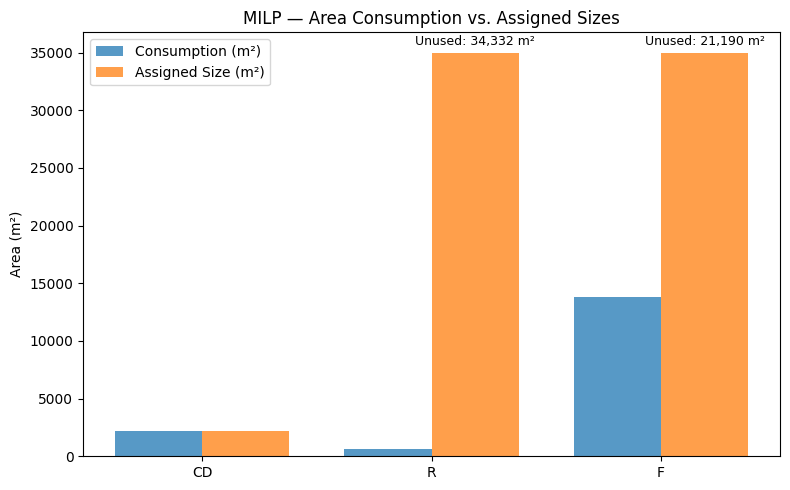

In [18]:
# Uses MILP outputs: sol_assign (dict product->flow), sol_sizes (dict area->size), and cons (dict area->consumption).
# If 'cons' is not present in scope, we recompute it from sol_assign.

import matplotlib.pyplot as plt

# Ensure we have consumption; recompute if needed
try:
    _ = cons  # just to check it exists
except NameError:
    feasible, _, _, _, cons = evaluate_assignment(sol_assign)

areas_labels = ["CD","R","F"]
cons_vals  = [float(cons[a]) for a in areas_labels]
sizes_vals = [float(sol_sizes[a]) for a in areas_labels]

x = range(len(areas_labels))
width = 0.38

plt.figure(figsize=(8,5))
bars1 = plt.bar(x, cons_vals, width, label="Consumption (m²)", alpha=0.75)
bars2 = plt.bar([i+width for i in x], sizes_vals, width, label="Assigned Size (m²)", alpha=0.75)

# Axis/labels
plt.xticks([i+width/2 for i in x], areas_labels)
plt.ylabel("Area (m²)")
plt.title("MILP — Area Consumption vs. Assigned Sizes")
plt.legend()

# Annotate unused space (Assigned - Consumption) when positive
for i, a in enumerate(areas_labels):
    gap = sizes_vals[i] - cons_vals[i]
    if gap > 0:
        # place annotation above the higher of the two bars
        y = max(cons_vals[i], sizes_vals[i])
        plt.text(i+width, y * 1.01, f"Unused: {gap:,.0f} m²", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


In [19]:
import pandas as pd
pd.DataFrame({
    "Area": areas_labels,
    "Consumption (m²)": cons_vals,
    "Assigned Size (m²)": sizes_vals,
    "Unused (m²)": [sv - cv for sv, cv in zip(sizes_vals, cons_vals)]
})


,Area,Consumption (m²),Assigned Size (m²),Unused (m²)
0,CD,2161.643836,2161.6438,-0.000036
1,R,668.153105,35000.0000,34331.846895
2,F,13810.275691,35000.0000,21189.724309
